In [47]:
import os
from datetime import datetime

import matplotlib.pyplot as plt
import networkx as nx
from node2vec import Node2Vec
import pandas as pd

In [48]:
df = pd.read_csv("../data/external/congress_trading_data_adrianmross.csv")

In [49]:
df["transaction_date"] = pd.to_datetime(df["transaction_date"])
df["type"] = df["type"].replace({"sale_partial": "sale", "sale_full": "sale"})

In [50]:
df["transaction_date"].min(), df["transaction_date"].max()

(Timestamp('2012-06-19 00:00:00'), Timestamp('2023-12-22 00:00:00'))

## Train-Test Split

In [51]:
df = df[df["transaction_date"].dt.year > 2016]
dfs_by_year = {year: group for year, group in df.groupby(df["transaction_date"].dt.year)}

In [52]:
def create_graph(df: pd.DataFrame) -> nx.Graph:
    G = nx.Graph()

    party_colors = {"Democrat": "blue", "Republican": "red"}
    party_map = {row["name"]: row["party"] for _, row in df.iterrows()}

    for rep in df["name"].unique():
        G.add_node(
            rep, color=party_colors.get(party_map[rep], "gray")
        )  # Default to gray if party unknown

    for ticker in df["ticker"].unique():
        ticker_trades = df[df["ticker"] == ticker]

        for i in range(len(ticker_trades)):
            for j in range(i + 1, len(ticker_trades)):
                rep1 = ticker_trades.iloc[i]["name"]
                rep2 = ticker_trades.iloc[j]["name"]
                date1 = ticker_trades.iloc[i]["transaction_date"]
                date2 = ticker_trades.iloc[j]["transaction_date"]
                trans_type1 = ticker_trades.iloc[i]["type"]
                trans_type2 = ticker_trades.iloc[j]["type"]

                if rep1 != rep2 and abs((date1 - date2).days) <= 7 and trans_type1 == trans_type2:
                    G.add_edge(rep1, rep2, stock=ticker)

    return G

In [53]:
graphs_by_year = {year: create_graph(df_year) for year, df_year in dfs_by_year.items()}

In [ ]:
def export_graph(folder, filename, file) -> None:
    os.makedirs(folder, exist_ok=True)
    nx.write_gml(file, f"../{folder}/{filename}")
    print(f"GML file saved as {folder}/{filename}")


folder = "data/internal/networks/ml"
export_graph(folder, "train_7d.gml", G_train)
export_graph(folder, "test_7d.gml", G_test)

GML file saved as data/internal/networks/ml/train_7d.gml
GML file saved as data/internal/networks/ml/test_7d.gml


In [55]:
def plot_graph(G, year):
    plt.figure(figsize=(12, 12))

    pos = nx.spring_layout(G, seed=42, k=1.5)

    node_colors = [data["color"] for _, data in G.nodes(data=True)]

    nx.draw_networkx_nodes(G, pos, node_size=500, node_color=node_colors, edgecolors="black")
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

    plt.title(year)
    plt.axis("off")
    plt.show()

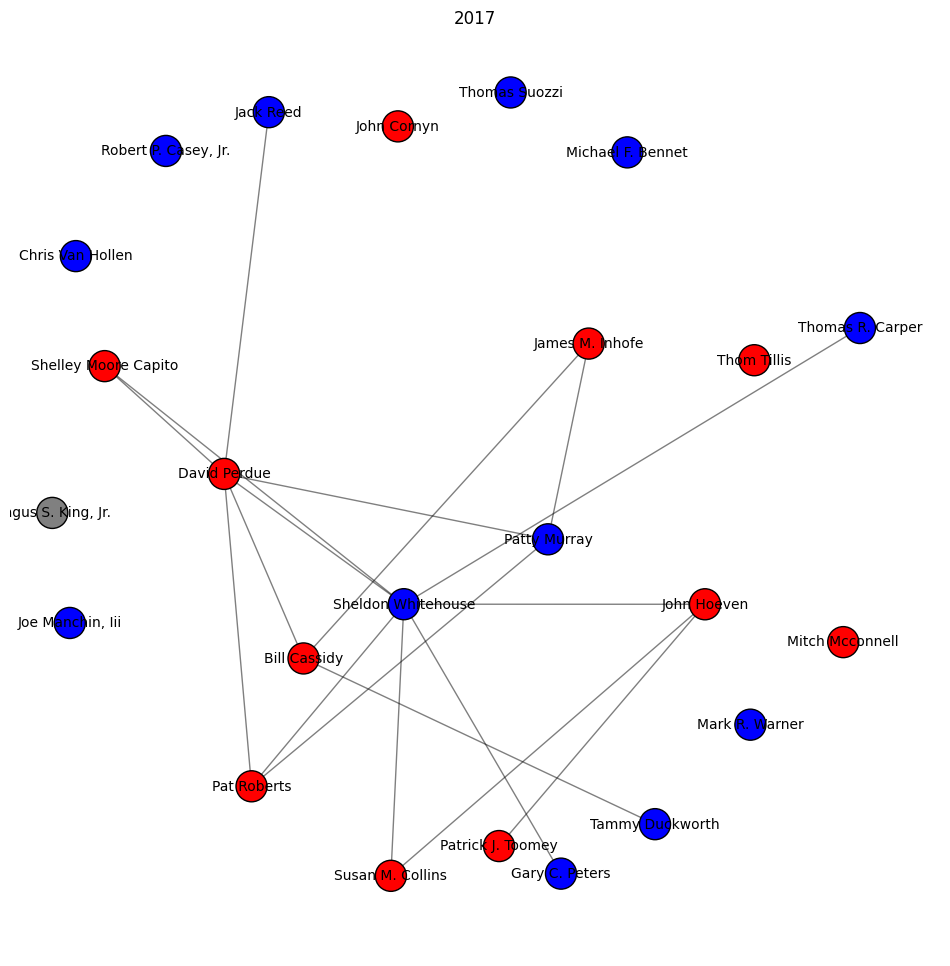

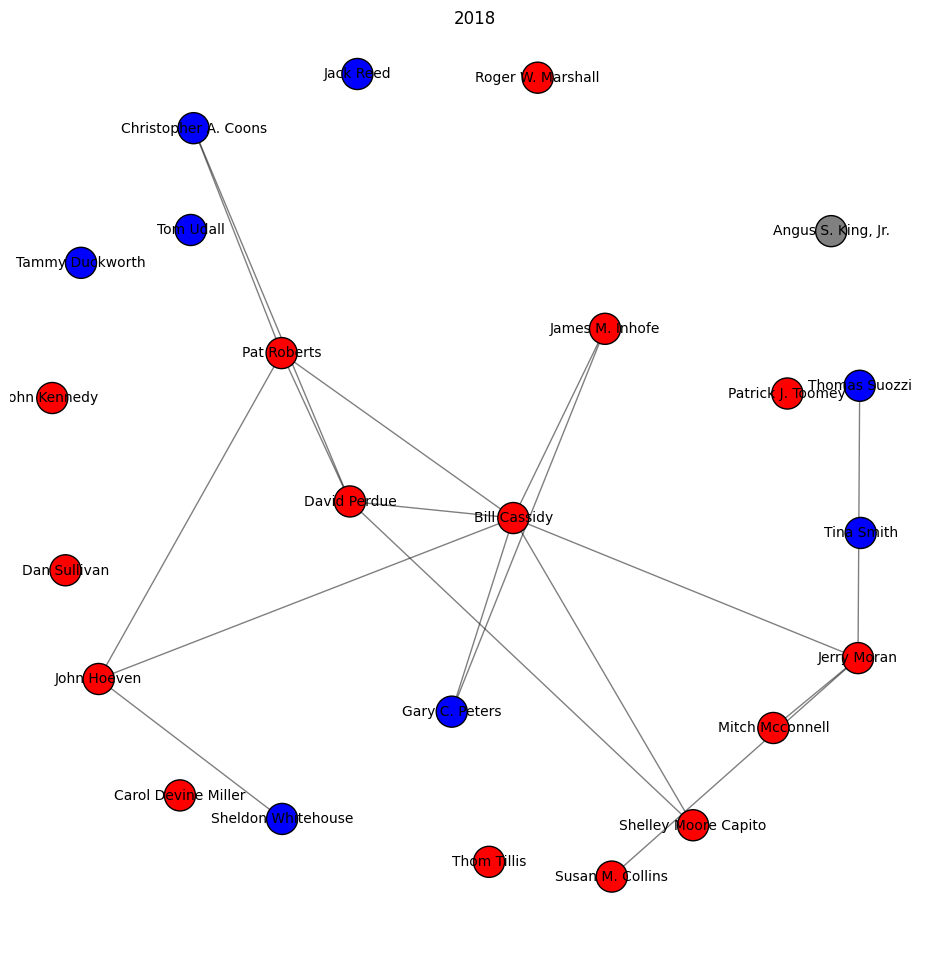

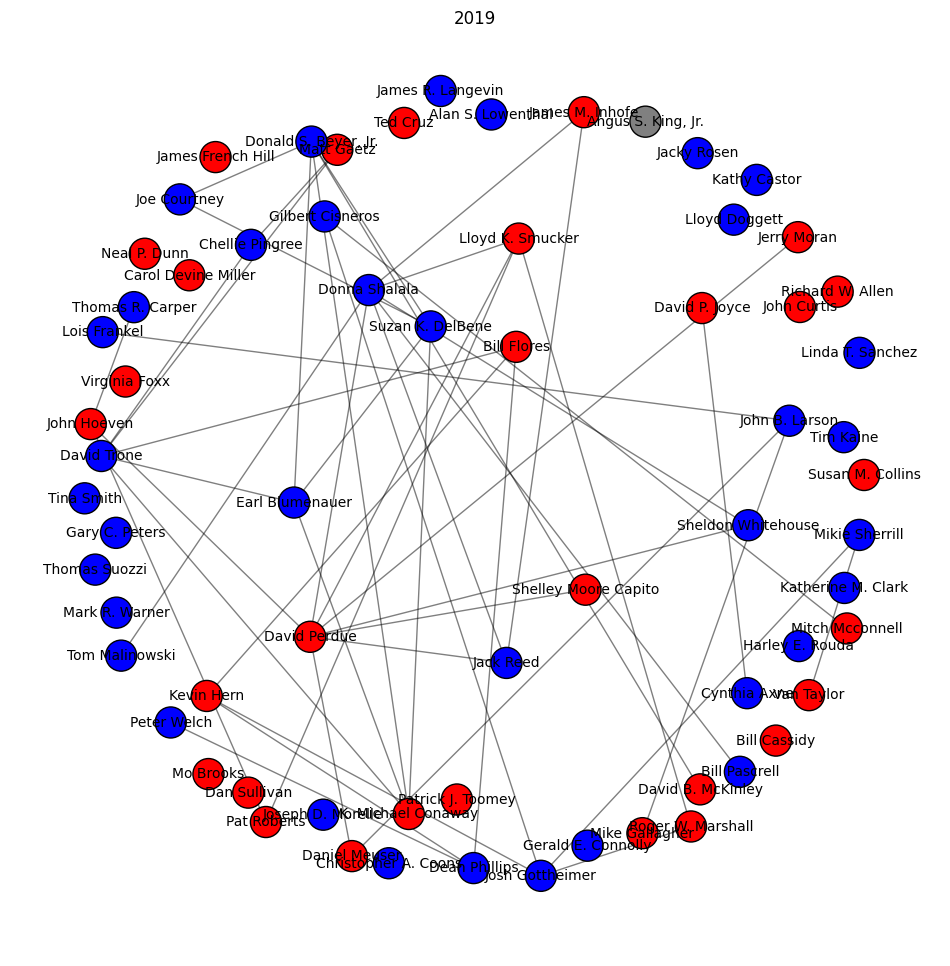

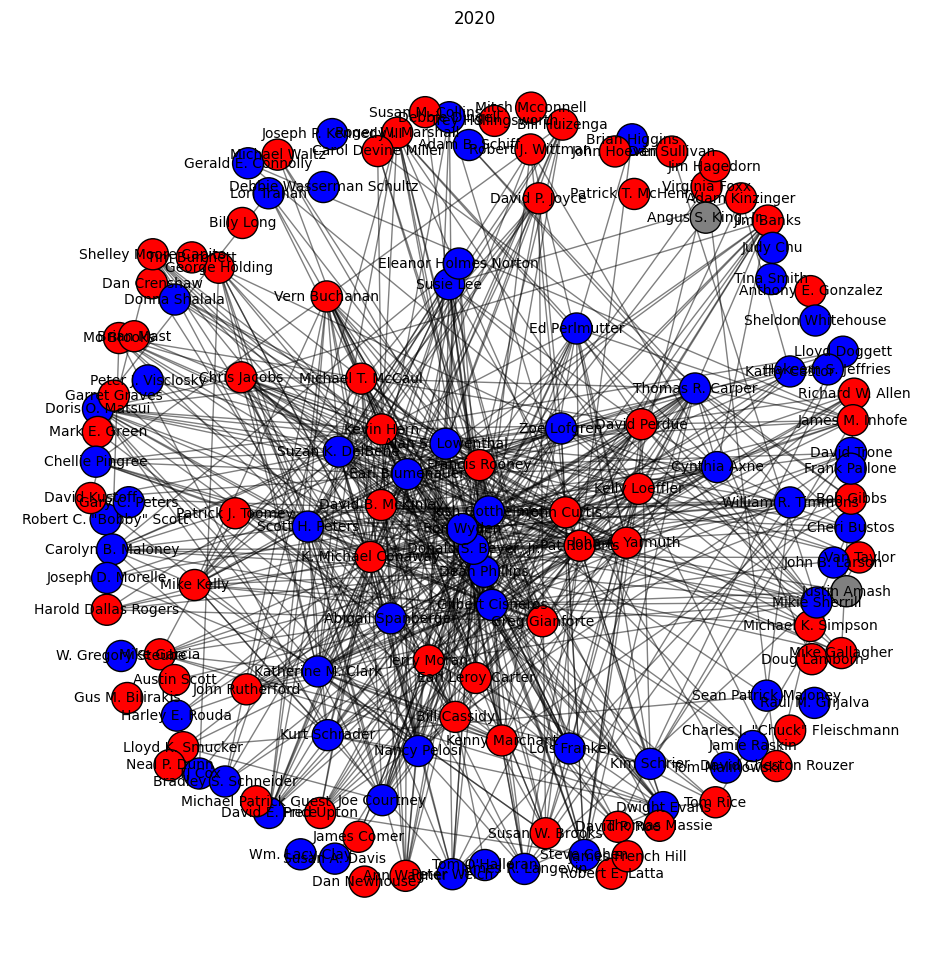

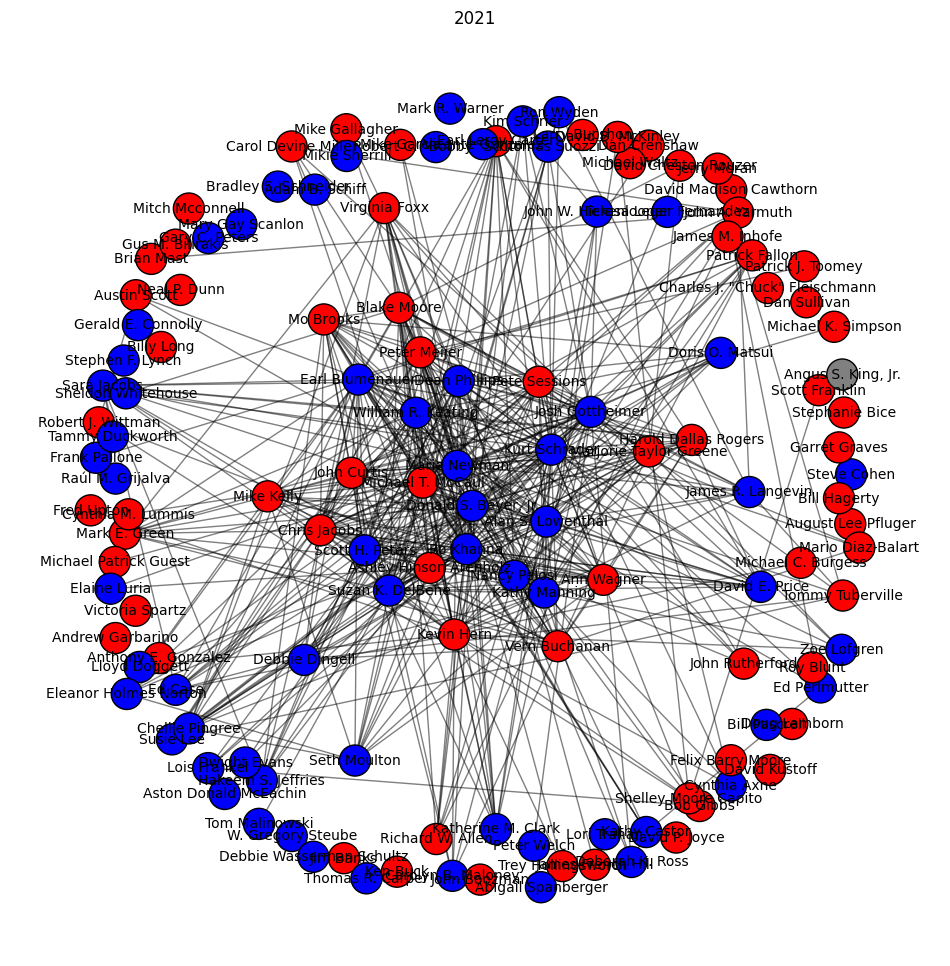

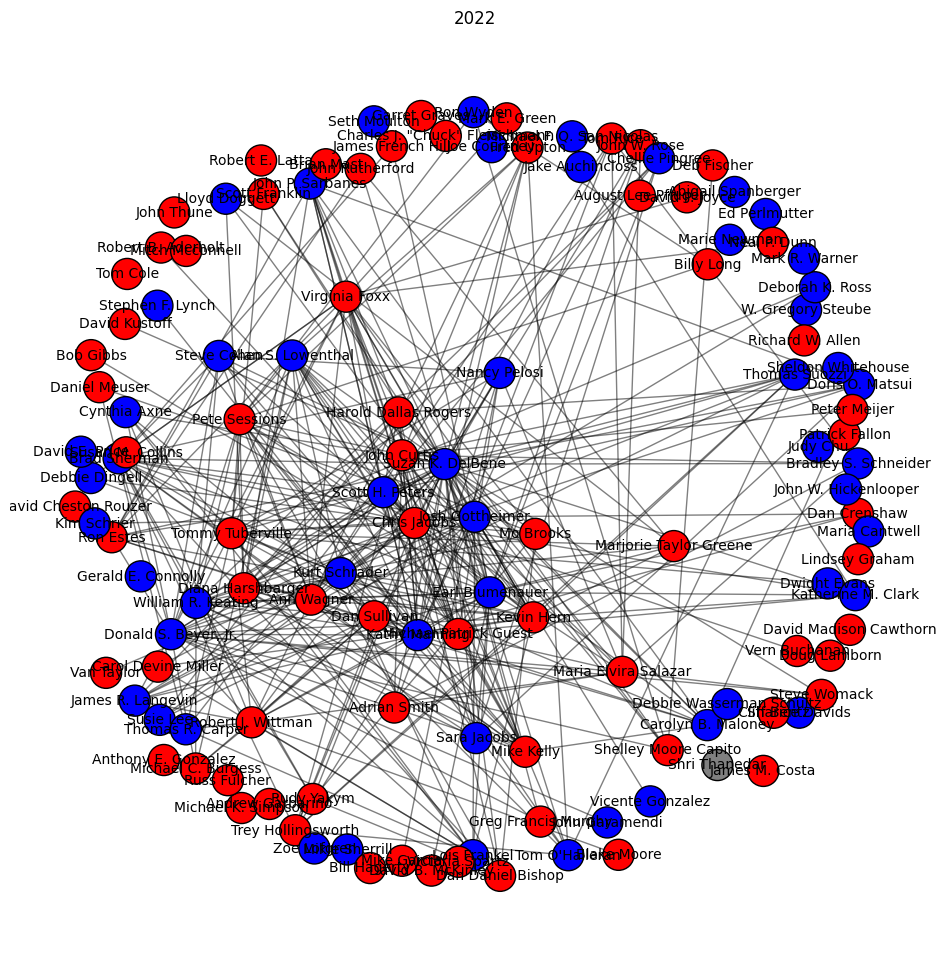

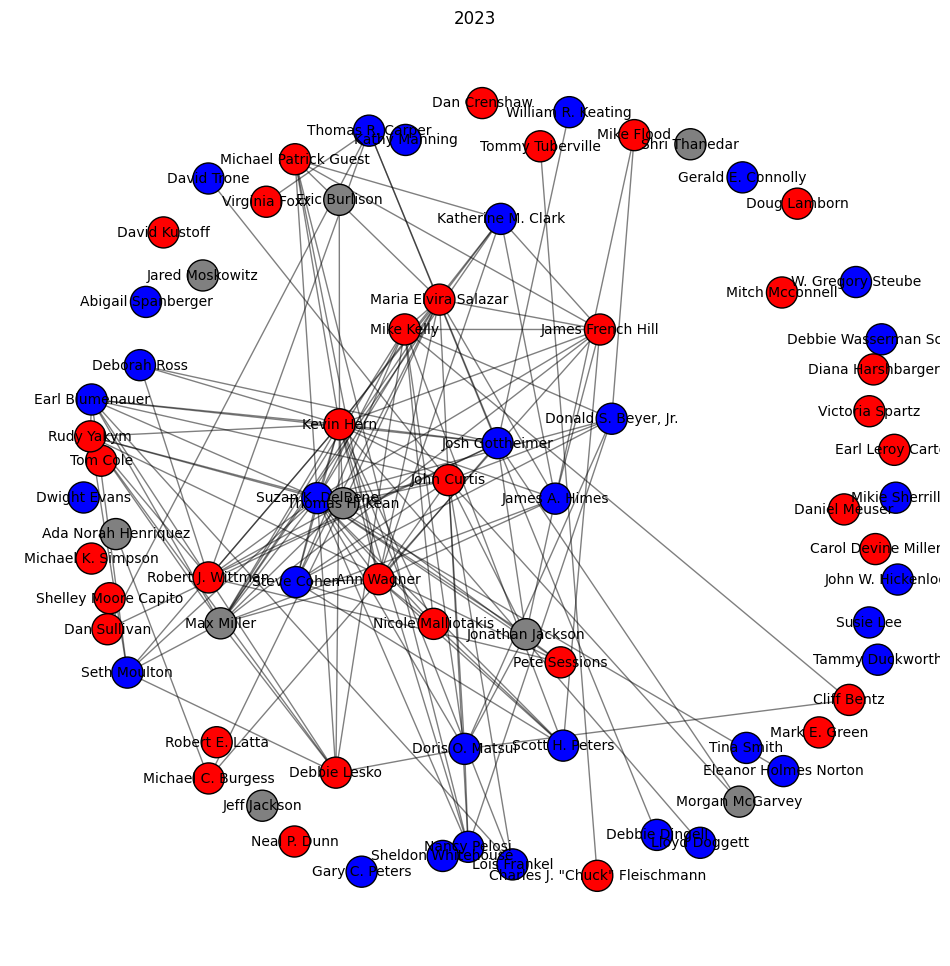

In [56]:
for year, g in graphs_by_year.items():
    plot_graph(g, year)

In [57]:
for year, graph in graphs_by_year.items():
    print(year, graph.number_of_edges())

2017 18
2018 17
2019 48
2020 720
2021 506
2022 349
2023 140


2015 6
2016 6
2017 18
2018 17
2019 48
2020 720
2021 506
2022 349
2023 140

Probably makes sense to remove years 2015 and 2016 too...

## Create Embeddings using Node2Vec

In [58]:
def create_embeddings(graph):
    node2vec = Node2Vec(graph, dimensions=16, walk_length=15, num_walks=100, workers=4)
    model = node2vec.fit(window=10, min_count=1)

    embeddings = pd.DataFrame(
        [model.wv.get_vector(str(node)) for node in graph.nodes()], index=graph.nodes
    )
    embeddings.index.name = "name"
    embeddings.reset_index(inplace=True)
    return embeddings

In [59]:
embeddings_by_year = {year: create_embeddings(graph) for year, graph in graphs_by_year.items()}

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:00<00:00, 896.32it/s]


In [90]:
df_returns = pd.read_csv("../data/external/congress_returns_adrianmross.csv")
df_returns["date"] = pd.to_datetime(df_returns["date"])
df_returns = df_returns[df_returns["date"].dt.year > 2016]
print(df_returns.head())

                 name       date    return  cum_return
0  Abigail Spanberger 2021-06-01  0.000000    0.000000
1  Abigail Spanberger 2021-06-02  0.007044    0.007044
2  Abigail Spanberger 2021-06-03  0.005578    0.012662
3  Abigail Spanberger 2021-06-04  0.012776    0.025600
4  Abigail Spanberger 2021-06-05  0.000000    0.025600


In [91]:
# Active periods for train and test
member_active_periods = (
    df_returns.groupby("name")
    .agg(start_date=("date", "min"), end_date=("date", "max"))
    .reset_index()
)


# Calculate yearly returns
def calculate_yearly_returns(returns_df):
    """
    Calculates yearly return metrics for each member.
    """
    # Add year column for grouping
    returns_df["year"] = returns_df["date"].dt.year

    # Group by name and year, then calculate metrics
    yearly_metrics = returns_df.groupby(["name", "year"]).agg(
        {"return": ["mean", "std", "sum"]}  # Mean, volatility, cumulative return
    )
    # Rename columns
    yearly_metrics.columns = ["avg_return", "return_volatility", "cumulative_return"]
    yearly_metrics.reset_index(inplace=True)

    return yearly_metrics


# Historical yearly returns for train and test sets
historical_returns = calculate_yearly_returns(df_returns)
historical_returns = pd.merge(historical_returns, member_active_periods, on="name", how="left")

we need to normalize the cum. return b.c. not all members have been active for the same amount of time.

In [92]:
df_sp500 = pd.read_csv("../data/external/s&p500_returns_adrianmross.csv") 
df_sp500["date"] = pd.to_datetime(df_sp500["date"])

In [93]:
def calculate_sp500_cumulative_return(start_date, end_date):
    print(start_date, end_date)
    mask = (df_sp500["date"] >= start_date) & (df_sp500["date"] <= end_date)
    sp500_period = df_sp500.loc[mask]
    cumulative_return = sp500_period["daily_return"].sum()
    return cumulative_return

In [94]:
historical_returns["sp500_cumulative_return"] = historical_returns.apply(
    lambda row: calculate_sp500_cumulative_return(
        max(row["start_date"], pd.Timestamp(f"{row['year']}-01-01")),
        min(row["end_date"], pd.Timestamp(f"{row['year']}-12-31")),
    ),
    axis=1,
)
historical_returns["normalized_return"] = (
    historical_returns["cumulative_return"] - historical_returns["sp500_cumulative_return"]
)

2021-06-01 00:00:00 2021-12-31 00:00:00
2022-01-01 00:00:00 2022-12-31 00:00:00
2023-01-01 00:00:00 2023-12-31 00:00:00
2024-01-01 00:00:00 2024-04-29 00:00:00
2023-04-10 00:00:00 2023-12-31 00:00:00
2024-01-01 00:00:00 2024-04-29 00:00:00
2020-04-03 00:00:00 2020-12-31 00:00:00
2021-01-01 00:00:00 2021-12-31 00:00:00
2022-01-01 00:00:00 2022-12-31 00:00:00
2023-01-01 00:00:00 2023-12-31 00:00:00
2024-01-01 00:00:00 2024-04-29 00:00:00
2019-12-11 00:00:00 2019-12-31 00:00:00
2020-01-01 00:00:00 2020-12-31 00:00:00
2021-01-01 00:00:00 2021-12-31 00:00:00
2022-01-01 00:00:00 2022-12-31 00:00:00
2023-01-01 00:00:00 2023-12-31 00:00:00
2024-01-01 00:00:00 2024-04-29 00:00:00
2021-04-23 00:00:00 2021-12-31 00:00:00
2022-01-01 00:00:00 2022-12-31 00:00:00
2023-01-01 00:00:00 2023-12-31 00:00:00
2024-01-01 00:00:00 2024-04-29 00:00:00
2017-11-28 00:00:00 2017-12-31 00:00:00
2018-01-01 00:00:00 2018-12-31 00:00:00
2019-01-01 00:00:00 2019-12-31 00:00:00
2020-01-01 00:00:00 2020-12-31 00:00:00


In [95]:
historical_returns_by_year = {year: df for year, df in historical_returns.groupby('year')}

In [97]:
features_by_year = {
    year: pd.merge(features, returns, on="name", how="inner")
    for (year, features), (_, returns) in zip(
        embeddings_by_year.items(), historical_returns_by_year.items()
    )
}

In [98]:
all_features = pd.concat(features_by_year.values(), keys=features_by_year.keys(), names=["year", "index"])

# Reset the index for better readability
all_features.reset_index(level=1, drop=True, inplace=True)

# Display the concatenated DataFrame
print(all_features.head())

                    name         0         1         2         3         4  \
year                                                                         
2017       Thomas Suozzi  0.049723 -0.030275  0.052648  0.032891 -0.040938   
2017         John Hoeven -0.213740  0.518215  0.131923  0.696819  0.271070   
2017  Sheldon Whitehouse -0.284399  0.527137  0.259324  0.630283 -0.056930   
2017        David Perdue -0.226065  0.510609 -0.045162  0.366880 -0.174350   
2017     James M. Inhofe -0.417036  0.349900 -0.120840  0.523344 -0.611883   

             5         6         7         8  ...        14        15  year  \
year                                          ...                             
2017  0.024737  0.034188 -0.046416 -0.046286  ...  0.009012 -0.005509  2017   
2017  0.001658  1.211786 -0.088856  0.069074  ... -1.301339  0.024946  2017   
2017 -0.096947  1.116871  0.156423  0.120423  ... -0.919411 -0.161796  2017   
2017  0.165647  1.134860  0.148497  0.389771  ... -0.68163

In [100]:
all_features.to_csv("../data/internal/ml/features_by_year.csv", index=False)